# Droughts

by Eszter Kovacs

In [2]:
import os
import numpy as np
import xarray as xr
import glob
import datetime
from datetime import datetime as dt
from pyhdf.SD import SD, SDC
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
pathname = '/gws/pw/j05/cop26_hackathons/leeds/'
from pathlib import Path
import xarray as xr

DATA_ROOT = Path("/badc/cmip6/data/CMIP6/")

def make_cmip6_filepath(institute, model, scenario, variant, experiment, table_id, variable, grid, version, time_range, data_root=DATA_ROOT):
    """
    Make a file path for a cmip6 dataset for a single variable
    Historical runs (1850-2014) are in `/badc/cmip6/data/CMIP6/CMIP/<institute>/<model>/historical/<variant>/<table_id>/<variable>/<grid>/<version>/`
    Scenario runs are in `/badc/cmip6/data/CMIP6/ScenarioMIP/<institute>/<model>/<scenario_name>/<variant>/<table_id>/<variable>/<grid>/<version>/`
    `scenario_name` is likely to be one of ssp119, ssp126, ssp245, ssp370 or ssp585
    `variant` takes the form `r<realiation_id>0<initialization_id>0<physics_id>0<forcing_id>`, e.g. `r1i1p1f2`, where the numbers are the indexes for:  
    **r**ealization, **i**nitialization, **p**hysics, **f**orcing
    `table_id` generally indicates the frequency of the data, e.g. day, 3hr, Amon
    `grid` is the model grid being used, e.g. gn, where  
       * `gm`: global mean data  
       * `gn`: data reported on a model's native grid  
       * `gr1`: regridded data reported on a grid other than the native grid and other than the preferred target grid  
    It is likely the `grid` will be the native grid, i.e. `gn`
    `version` normally in the form `v[YYYYMMDD]` or `latest`, e.g. `v20200203
    
    `variable` generally follows the list on https://pcmdi.llnl.gov/mips/cmip3/variableList.html, for example 
       `tas`: air_temperature 
       `pr`: precipitation_flux
       `ts`: surface_temperature
    The following institutions have data in both historical and ScenarioMIPs:
    AS-RCEC, AWI, BCC, CAMS, CAS, CCCR-IITM, CCCma, CMCC, CNRM-CERFACS, CSIRO, CSIRO-ARCCSS, E3SM-Project, EC-Earth-Consortium, FIO-QLNM, HAMMOZ-Consortium, INM, IPSL, KIOST, MIROC, MOHC, MPI-M, MRI, NASA-GISS, NCAR, NCC, NIMS-KMA, NOAA-GFDL, NUIST, THU, UA
    """
    path = DATA_ROOT / scenario / institute / model / experiment / variant / table_id / variable / grid / version
    filename = f"{variable}_{table_id}_{model}_{experiment}_{variant}_{grid}_{time_range}.nc"
    
    return path / filename
  
  
# load a file
fp = make_cmip6_filepath(
    institute="MOHC", scenario="ScenarioMIP", model="HadGEM3-GC31-LL", experiment="ssp585", variant="r1i1p1f3",
    table_id="day", variable="pr", grid="gn", version="v20200114", time_range="20150101-20491230"
)
ds = xr.open_dataset(fp)

# check what files are available
fp = make_cmip6_filepath(
    institute="MOHC", scenario="ScenarioMIP", model="HadGEM3-GC31-LL", experiment="ssp585", variant="r1i1p1f3",
    table_id="day", variable="pr", grid="gn", version="v20200114", time_range="*"
)
list(fp.parent.glob(fp.name))

[PosixPath('/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31-LL/ssp585/r1i1p1f3/day/pr/gn/v20200114/pr_day_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_20150101-20491230.nc'),
 PosixPath('/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31-LL/ssp585/r1i1p1f3/day/pr/gn/v20200114/pr_day_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_20500101-21001230.nc')]

# Visualise at some time over Ghana

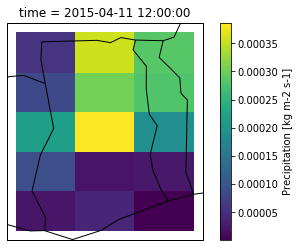

In [4]:
# change longitudes from 0,360 to -180,180
ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
# include only data over Ghana
smallds = ds.where((ds.lon>-3.38)*(ds.lon<1.25)*(ds.lat>5)*(ds.lat<11.09), drop = True)
import cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS)
ax.coastlines()
smallds.pr[100,:,:].plot(ax = ax)

# Time series

Text(0, 0.5, 'Precipitation (kg m-2 s-1)')

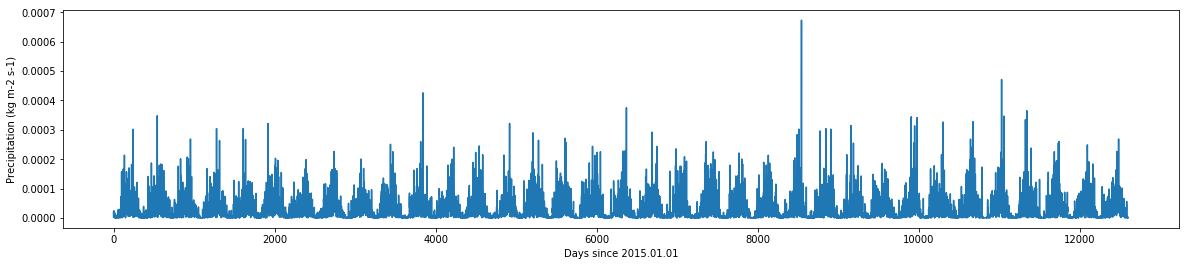

In [5]:
plt.figure(figsize = (20,4))
plt.plot(smallds.pr.mean(['lat', 'lon'])[:].data)
plt.xlabel('Days since 2015.01.01')
plt.ylabel('Precipitation (kg m-2 s-1)')

Text(0, 0.5, 'Drought lengths (days)')

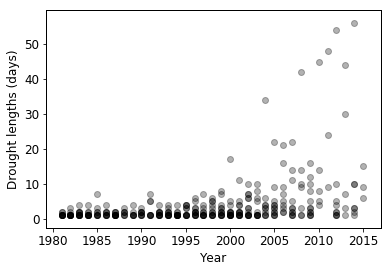

In [18]:
# convert to mm/day
mmday = smallds.pr*86400
drought = mmday.mean(['lat', 'lon'])<1
droughts = [np.sum(drought[365*i : 365*(i+1)].data) for i in range(33)]

# font settings
s = 12
font = {'weight' : 'normal',
        'size'   : s,
        'serif': 'Arial'}

plt.rc('font', **font)
plt.rc('axes', linewidth=1)

condition = drought.data
cons = [[0]]*35
for i in range(35):
    summerstart = 151 # May 31
    summerend = 244 # Sept 1
    cond = drought[365*i + summerstart : 365*i + summerend].data
    cons[i] = np.diff(np.where(np.concatenate(([cond[0]],
                                     cond[:-1] != cond[1:],
                                     [True])))[0])[::2]
    plt.scatter([i+1981]*len(cons[i]), cons[i], c = 'k', alpha = 0.3)
plt.xlabel('Year')
plt.ylabel('Drought lengths (days)')

In [24]:
mmday.mean(['lat', 'lon']).data.mean()

2.418305389495553

In [17]:
244-151

93

Text(0.5, 0, 'Year')

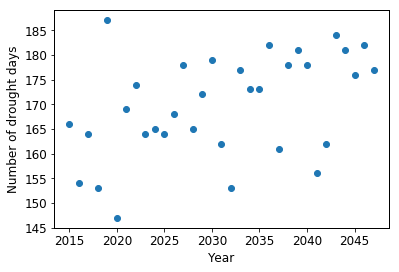

In [7]:
# font settings
s = 12
font = {'weight' : 'normal',
        'size'   : s,
        'serif': 'Arial'}

plt.rc('font', **font)
plt.rc('axes', linewidth=1)

plt.scatter(np.arange(33)+2015,droughts)
plt.ylabel('Number of drought days')
plt.xlabel('Year')